In [1]:
# starting code
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


| PyTorch module                                                              | What does it do?                                                                                                                                                                                                                                                                                                                       |
| --------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| [torchvision](https://pytorch.org/vision/stable/index.html)                 | Contains datasets, model architectures and image transformations often used for computer vision problems.                                                                                                                                                                                                                              |
| [torchvision.datasets](https://pytorch.org/vision/stable/datasets.html)     | [Here you'll find many example computer vision datasets for a range of problems from image classification, object detection, image captioning, video classification and more. It also contains a series of base classes for making custom datasets.](https://pytorch.org/vision/stable/datasets.html#base-classes-for-custom-datasets) |
| [torchvision.models](https://pytorch.org/vision/stable/models.html)         | This module contains well-performing and commonly used computer vision model architectures implemented in PyTorch, you can use these with your own problems.                                                                                                                                                                           |
| [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html) | Often images need to be transformed (turned into numbers/processed/augmented) before being used with a model, common image transformations are found here.                                                                                                                                                                             |

In [2]:
# Import torchvision 
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

### set up data

In [3]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

In [4]:
# first training example
image, label = train_data[0]
print(image.shape, label)

torch.Size([1, 28, 28]) 9


Order of the tensor is commonly CHW - Color channels, Height, Width. Add N in front to indicate batch size

Pytorch generally use NCHW as default, althought channels last is considered best practice (i.e. NHWC)

https://pytorch.org/blog/tensor-memory-format-matters/#pytorch-best-practice

In [5]:
train_data.targets.max()

tensor(9)

### visualise the data

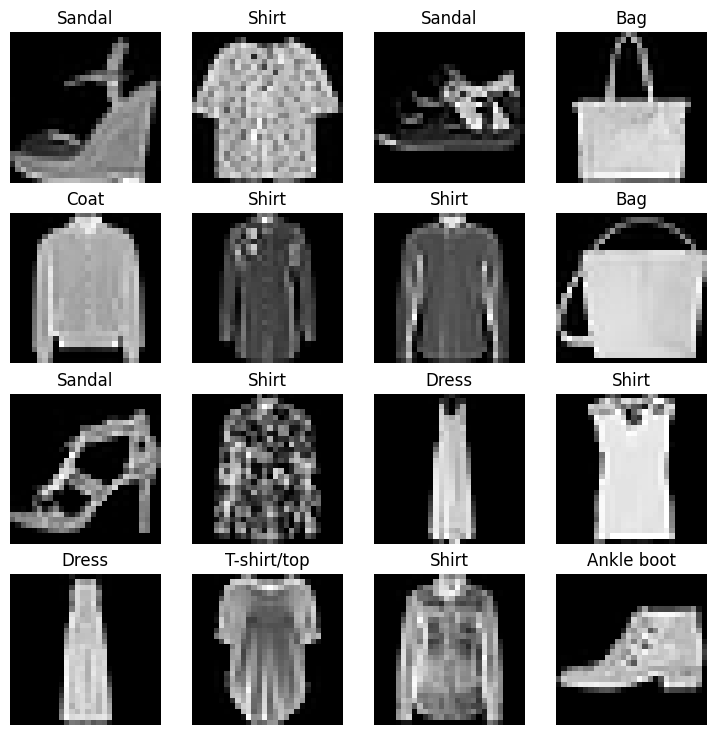

In [6]:
# Plot more images
torch.manual_seed(13)
class_names = train_data.classes
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

### dataloader

so far, in exercise 2 and 3 we were loading the entire data into forward and backward pass at once, but as data gets bigger, this may not be feasible.

We will use data loader to break the data into chunks - or mini-batches. Gradient descent is performed more than once per epoch

In [7]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


### Building a baseline model with simple linear layers

In [8]:
input_shape = train_data[0][0].shape
NUM_FEATURES = input_shape[1] * input_shape[2]
NUM_CLASSES = len(train_data.classes)

class FashionMnistClassificationModelV0(nn.Module):
    def __init__(self):
        super().__init__()        
        self.layer_1 = nn.Linear(in_features=NUM_FEATURES, out_features=10)        
        self.layer_2 = nn.Linear(in_features=10, out_features=NUM_CLASSES) # set the final layer to output the same number of classes
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
    
    # 2. Define the forward method - i.e. how is each record of x computed
    def forward(self, x):
        layer_0_output = self.flatten(x)
        layer_1_output = self.relu(self.layer_1(layer_0_output))        
        return self.layer_2(layer_1_output)

model_v0 = FashionMnistClassificationModelV0()
model_v0.to(device)

# Define loss function
loss_fn = nn.CrossEntropyLoss() 

# Create an optimizer
optimizer = torch.optim.SGD(params=model_v0.parameters(), lr=0.1)

# Calculate accuracy
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [9]:
# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

# pytorch training loop
def training(model, epochs):
    for epoch in range(epochs):
        ### MODEL TRAINING
        train_loss, train_acc = 0, 0
       
        # 0. Put model in training mode
        model.train()
        for batch, (X, y) in enumerate(train_dataloader):            
            # 1. Forward pass
            y_train_logits = model(X)
            y_train_probs = torch.softmax(y_train_logits, dim=1) # softmax calculation across dimension #1 (i.e. the one with 4 class values)
            y_train_pred = torch.argmax(y_train_probs, dim=1) # find position of highest prob

            # 2. Calculate loss & accuracy
            loss = loss_fn(y_train_logits, y)
            train_loss += loss / len(train_dataloader)
            train_acc += accuracy_fn(y_train_pred, y) / len(train_dataloader)            
            
            # 3. zero gradients - optimizer gradients are set to zero so they can be recalcualted for the specific training step
            optimizer.zero_grad()

            # 4. Backpropagation on loss -  calculate loss gradients
            loss.backward()

            # 5. Update the parameters (every model parameter with requires_grad = True) with respect to the loss gradients
            optimizer.step()

            # Print out how many samples have been seen
            if batch % 400 == 0:
                print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")
                
        ### MODEL Testing
        test_loss, test_acc = 0, 0

        # 0. Put model in evaluation mode
        model.eval()

        # 1. use inference mode to do predictions on test data
        with torch.inference_mode():
            for batch, (X, y) in enumerate(test_dataloader):
                y_test_logits = model(X)
                y_test_probs = torch.softmax(y_test_logits, dim=1)
                y_test_pred = torch.argmax(y_test_probs, dim=1)

                test_loss += loss_fn(y_test_probs, y) / len(test_dataloader)
                test_acc += accuracy_fn(y_test_pred, y) / len(test_dataloader)

        if epoch % 1 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(train_loss.item())
            test_loss_values.append(test_loss.item())
            print(f"Step {epoch}: training loss is {train_loss}, test loss is {test_loss}, training accuracy is {train_acc}, test accuracy is {test_acc}")

training(model=model_v0, epochs=5)

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Step 0: training loss is 0.6521790623664856, test loss is 1.7106682062149048, training accuracy is 76.77333333333401, test accuracy is 80.16174121405768
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Step 1: training loss is 0.5025765895843506, test loss is 1.697955846786499, training accuracy is 82.33000000000085, test accuracy is 81.36980830670944
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Step 2: training loss is 0.4777888357639313, test loss is 1.6996212005615234, training accuracy is 83.10833333333407, test accuracy is 81.42971246006405
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60

### Building a convolution neural network

Will build a simple structure of Input layer -> [Convolutional layer -> activation layer -> pooling layer] -> Output layer

In [10]:
input_shape = train_data[0][0].shape
NUM_FEATURES = input_shape[1] * input_shape[2]
NUM_CLASSES = len(train_data.classes)
INPUT_CHANNEL = input_shape[0]
HIDDEN_UNITS = 8

class FashionMnistClassificationModelV1(nn.Module):
    def __init__(self):
        super().__init__()

        self.block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=INPUT_CHANNEL,
                out_channels=HIDDEN_UNITS,
                kernel_size=3, # how big is the square that's going over the image?
                stride=1, # default
                padding=1# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number

            ),
            nn.ReLU(),
            nn.Conv2d(in_channels=HIDDEN_UNITS, 
                      out_channels=HIDDEN_UNITS,
                      kernel_size=3,
                      stride=1,
                      padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=HIDDEN_UNITS,
                out_channels=HIDDEN_UNITS,
                kernel_size=3, # how big is the square that's going over the image?
                stride=1, # default
                padding=1# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number

            ),
            nn.ReLU(),
            nn.Conv2d(in_channels=HIDDEN_UNITS, 
                      out_channels=HIDDEN_UNITS,
                      kernel_size=3,
                      stride=1,
                      padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)            
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features=HIDDEN_UNITS * 7 * 7, out_features=NUM_CLASSES)
    
    # 2. Define the forward method - i.e. how is each record of x computed
    def forward(self, x):
        block_1_output = self.block_1(x)
        block_2_output = self.block_2(block_1_output)
        block_3_output = self.flatten(block_2_output)       
        final_output = self.linear(block_3_output)
        return final_output

model_v1 = FashionMnistClassificationModelV1()
model_v1.to(device)

# Define loss function
loss_fn = nn.CrossEntropyLoss() 

# Create an optimizer
optimizer = torch.optim.SGD(params=model_v1.parameters(), lr=0.1)

# Calculate accuracy
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [11]:
# test network is set up correctly with shapes and channels
model_v1(next(iter(train_dataloader))[0])

tensor([[-0.1058,  0.0276,  0.0933,  0.0734, -0.0219, -0.0384, -0.0041, -0.0572,
          0.0633,  0.0199],
        [-0.1100,  0.0231,  0.0865,  0.0715, -0.0275, -0.0393, -0.0105, -0.0408,
          0.0683,  0.0214],
        [-0.1063,  0.0220,  0.0936,  0.0705, -0.0201, -0.0331, -0.0072, -0.0521,
          0.0601,  0.0169],
        [-0.1090,  0.0190,  0.0925,  0.0696, -0.0212, -0.0364, -0.0091, -0.0459,
          0.0663,  0.0206],
        [-0.1063,  0.0262,  0.0892,  0.0710, -0.0218, -0.0425, -0.0061, -0.0468,
          0.0677,  0.0217],
        [-0.1068,  0.0268,  0.0920,  0.0696, -0.0236, -0.0417, -0.0053, -0.0490,
          0.0646,  0.0246],
        [-0.1090,  0.0286,  0.0886,  0.0734, -0.0244, -0.0358, -0.0055, -0.0481,
          0.0666,  0.0206],
        [-0.1070,  0.0267,  0.0935,  0.0732, -0.0177, -0.0374, -0.0056, -0.0523,
          0.0624,  0.0166],
        [-0.1082,  0.0193,  0.0913,  0.0730, -0.0246, -0.0383, -0.0066, -0.0501,
          0.0630,  0.0170],
        [-0.1095,  

In [12]:
training(model=model_v1, epochs=5)

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Step 0: training loss is 0.6644343733787537, test loss is 1.6845159530639648, training accuracy is 75.61000000000057, test accuracy is 83.49640575079883
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Step 1: training loss is 0.3958551585674286, test loss is 1.6423099040985107, training accuracy is 85.64666666666709, test accuracy is 85.37340255591073
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Step 2: training loss is 0.35761046409606934, test loss is 1.6168690919876099, training accuracy is 87.12500000000021, test accuracy is 87.22044728434521
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/

Model accuracy has improved by around 6%.

Next let's look at what Cov2d and MaxPool2d are doing

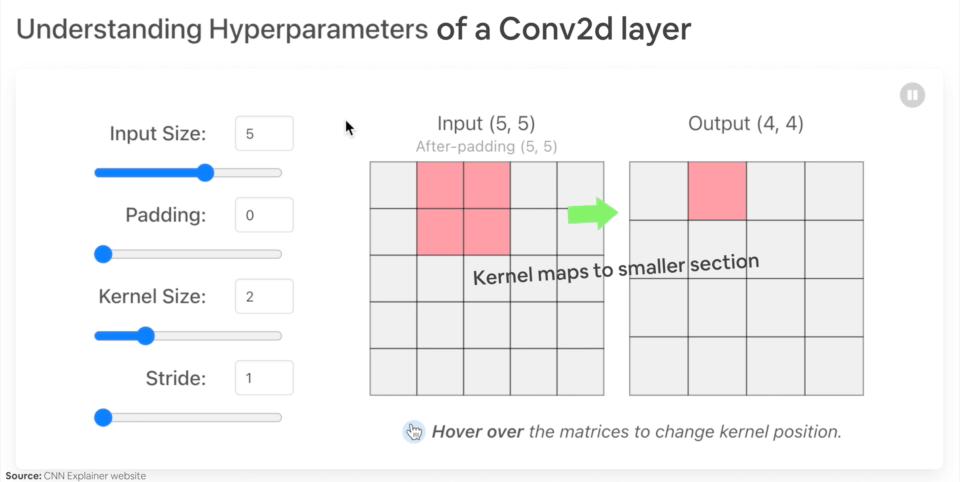

In [13]:
sample_image = train_data[0][0]

print(sample_image.shape)

torch.Size([1, 28, 28])


In [14]:
# conv2D expects 4 dimensional input with size (N,C,H,W)
# we use unsqueeze to add a dummy extra dimension

sample_image.unsqueeze(dim=0).shape

torch.Size([1, 1, 28, 28])

In [15]:
conv_layer = nn.Conv2d(in_channels=1,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=1)

conv_layer(sample_image.unsqueeze(dim=0)).shape

# output shape [a,b,c,d] is based on
# a = batch size
# b = out_channels
# c = original image (pixels - kernel size + 2* padding + stride)/ stride. in this example, (28 - 3 + 2 * 1 + 1)/1 = 28
# d sample as c if square image

torch.Size([1, 10, 28, 28])

In [16]:
conv_layer = nn.Conv2d(in_channels=1,
                       out_channels=10,
                       kernel_size=4,
                       stride=2,
                       padding=0)

conv_layer(sample_image.unsqueeze(dim=0)).shape

# c = (28 - 4 + 2 * 0 + 2)/2 = 13
# d sample as c if square image

torch.Size([1, 10, 13, 13])

Every layer in a neural network is trying to compress data from higher dimensional space to lower dimensional space.

MaxPool2d - take the maximum value from a portion of a tensor and disregard the rest

In [17]:
# example

torch.manual_seed(42)
# Create a random tensor with a similiar number of dimensions to our images
random_tensor = torch.randn(size=(1, 1, 2, 2))
print(f"Random tensor:\n{random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")

# Create a max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2) # see what happens when you change the kernel_size value 

# Pass the random tensor through the max pool layer
max_pool_tensor = max_pool_layer(random_tensor)
print(f"\nMax pool tensor:\n{max_pool_tensor} <- this is the maximum value from random_tensor")
print(f"Max pool tensor shape: {max_pool_tensor.shape}")

Random tensor:
tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])

Max pool tensor:
tensor([[[[0.3367]]]]) <- this is the maximum value from random_tensor
Max pool tensor shape: torch.Size([1, 1, 1, 1])
